# Supervised ML project - Predicting stroke
The dataset consists of 11 features:
* ID
* Gender (M/F/Other)
* Age
* Hypertension (binary)
* Heart disease (binary)
* Married (binary)
* Work
* Residence (urban/rural)
* Average glucose level
* BMI
* Smoker (formerly/currently (Y/N)/unknown)

Target variable is stroke, binary. 1 for yes 0 for no


# EDA

In [106]:
import pandas as pd
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.drop(columns = "id", inplace=True)
df.dropna(inplace = True)
df["gender"] = df.gender.apply(lambda x: "Female" if x=="Other" else x)

# EDA - conclusions
 - There are many outliers in several of the features, in order to handle these, `RobustScaler()` will be applied when scaling numerical data. 
 - `NaN`s are thankfully fairly few and are only present in the BMI column. These will be imputed and set to the median BMI, although the mean and median are very similar (good).
 
# Strategy for learning
In addition to the usual process of scoring and optimizing hyperparameters for various classification models, the features will be 'optimized' as in all possible combinations of features will be tested. 

# Split data

### Data is highly imbalanced, we will solve this with oversampling

In [107]:
import imblearn
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# Upsample the strokes so that they constitute 20% of the set

sample_size = int(0.25*df.loc[df.stroke==0].shape[0]-df.loc[df.stroke==1].shape[0])

sample = df.loc[df.stroke==1].sample(n = sample_size, replace=True, random_state = 42)
df = pd.concat([df,sample])
df.reset_index(drop=True, inplace=True)

target = "stroke"
X = df.drop(columns = target)
y = df[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# Set up initial evaluation of models/classifiers & preprocessing

In [109]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

classifiers = [LogisticRegression(),
               DecisionTreeClassifier(),
               RandomForestClassifier(),
               SVC(),
               KNeighborsClassifier()]

from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder

num_cols = make_column_selector(dtype_include = "number")
cat_cols = make_column_selector(dtype_include = "object")

num_tran = RobustScaler()
cat_tran = OneHotEncoder()

preprocessing = make_column_transformer((num_tran, num_cols), (cat_tran, cat_cols))

# Set up `GridSearchCV`

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

for i in classifiers:
    pipe = make_pipeline(preprocessing, i)
    grid = GridSearchCV(estimator = pipe, 
                        cv = 5,
                        scoring = "roc_auc",
                        param_grid = {})
    
    grid.fit(X_train,y_train)
    print(f"Score for {i}: {grid.best_score_}")

Score for LogisticRegression(): 0.8524330486052992
Score for DecisionTreeClassifier(): 0.9544691284288035
Score for RandomForestClassifier(): 0.9895228733669542
Score for SVC(): 0.8881331641930827
Score for KNeighborsClassifier(): 0.9217379260578588


# Check feature importances
This will be done if time allows for it since it will require manual dummying

# Move on with `RandomForestClassifier()`

# Perform feature tuning

In [110]:
import itertools

cols = list(X_train.columns)
combinations = {}

for i in range(1, len(cols)+1):
    combinations[i] = list(itertools.combinations(cols, r = i))

# For `RandomForestClassifier()`:

In [111]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
import warnings
warnings.filterwarnings('ignore')
import os
from joblib import dump

models_rf = {1:[],
          2:[],
          3:[],
          4:[],
          5:[],
          6:[],
          7:[],
          8:[],
          9:[],
          10:[]
            }

scaler = RobustScaler()
encoder = OneHotEncoder(drop = "if_binary")

#os.chdir('C:\\Users\\victo\\00_Nod_coding_bootcamp\\Week 9\\Project\\models\\RandomForest')

for num_of_feats in combinations.keys():
    print(num_of_feats,"Features...")
    for combination in combinations[num_of_feats]:
        
        X_train_temp = X_train[list(combination)]
        X_test_temp = X_test[list(combination)]
        y_train_temp = y_train
        y_test_temp = y_test
        
        #num_cols_temp = make_column_selector(dtype_include="number")
        #cat_cols_temp = make_column_selector(dtype_include="object")
        
        #preproc_temp = make_column_transformer((scaler, num_cols_temp), (encoder, cat_cols_temp))
        
        pipe = make_pipeline(preprocessing, RandomForestClassifier(random_state = 42))
        pipe.fit(X_train_temp, y_train_temp)
        
        y_true_temp = y_test_temp
        y_pred_temp = pipe.predict(X_test_temp)
        M = confusion_matrix(y_true_temp, y_pred_temp)
        
        
        
        scores = {"accuracy": accuracy_score(y_true_temp, y_pred_temp),
                  "precision": precision_score(y_true_temp, y_pred_temp),
                  "recall_": recall_score(y_true_temp, y_pred_temp),
                  "f1_score": f1_score(y_true_temp, y_pred_temp),
                  "roc_auc": roc_auc_score(y_true_temp, y_pred_temp)}
        
        models_rf[num_of_feats].append((pipe,
                                     f1_score(y_true_temp, y_pred_temp),
                                     combination,
                                     M,
                                     scores))
        
    print("Best F1 score:",round(max(models_rf[num_of_feats], key = lambda x: x[1])[1],5),"\n")
    print("With confusion matrix:")
    print(M)
    print("\nAnd with combination:")
    print(max(models_rf[num_of_feats], key = lambda x: x[1])[2])
    print("\n\n-------------------------------------------------------------------------------------------")
    
    # Save the best model for the current number of features in the combo
    
    combo = max(models_rf[num_of_feats], key = lambda x: x[1])[2]
    model = pipe.fit(X_train[list(combo)], y_train)
    name = f"RandomForest_{num_of_feats}_feats.joblib"
    dump(model, name)
    
best_models_rf = {}

for i in models_rf.keys():
    best_model_rf = max(models_rf[i], key = lambda x: x[1])
    best_models_rf[i] = {"pipeline" : best_model_rf[0],
                         "f1_score" : best_model_rf[1],
                         "combination" : best_model_rf[2],
                         "matrix" : best_model_rf[3],
                         "all_scores" : best_model_rf[4],}
    
#os.chdir('C:\\Users\\victo\\00_Nod_coding_bootcamp\\Week 9\\Project')

1 Features...
Best F1 score: 0.87964 

With confusion matrix:
[[1160    0]
 [ 309    0]]

And with combination:
('avg_glucose_level',)


-------------------------------------------------------------------------------------------
2 Features...
Best F1 score: 0.92857 

With confusion matrix:
[[1067   93]
 [ 109  200]]

And with combination:
('avg_glucose_level', 'bmi')


-------------------------------------------------------------------------------------------
3 Features...
Best F1 score: 0.96013 

With confusion matrix:
[[1130   30]
 [  10  299]]

And with combination:
('age', 'avg_glucose_level', 'bmi')


-------------------------------------------------------------------------------------------
4 Features...
Best F1 score: 0.95775 

With confusion matrix:
[[1138   22]
 [  10  299]]

And with combination:
('age', 'work_type', 'avg_glucose_level', 'bmi')


-------------------------------------------------------------------------------------------
5 Features...
Best F1 score: 0.96815 



### Predict test data

In [27]:
from joblib import load
import os

#os.chdir(('C:\\Users\\victo\\00_Nod_coding_bootcamp\\Week 9\\Project\\models\\RandomForest'))


test_scores = {}

for i, j in best_models_rf.items():
    model = load(f"RandomForest_{i}_feats.joblib")
    model.fit(X_train[list(j["combination"])],y_train)
    
    y_true = y_test
    y_pred = model.predict(X_test[list(j["combination"])])
    
    test_scores[i] = [list(j["combination"]), {"Accuracy" : accuracy_score(y_true,y_pred),
                                               "Precision" : precision_score(y_true,y_pred),
                                               "Recall" : recall_score(y_true,y_pred),
                                               "F1" : f1_score(y_true,y_pred),
                                               "ROC/AUC" : roc_auc_score(y_true,y_pred),}]


### Plot things

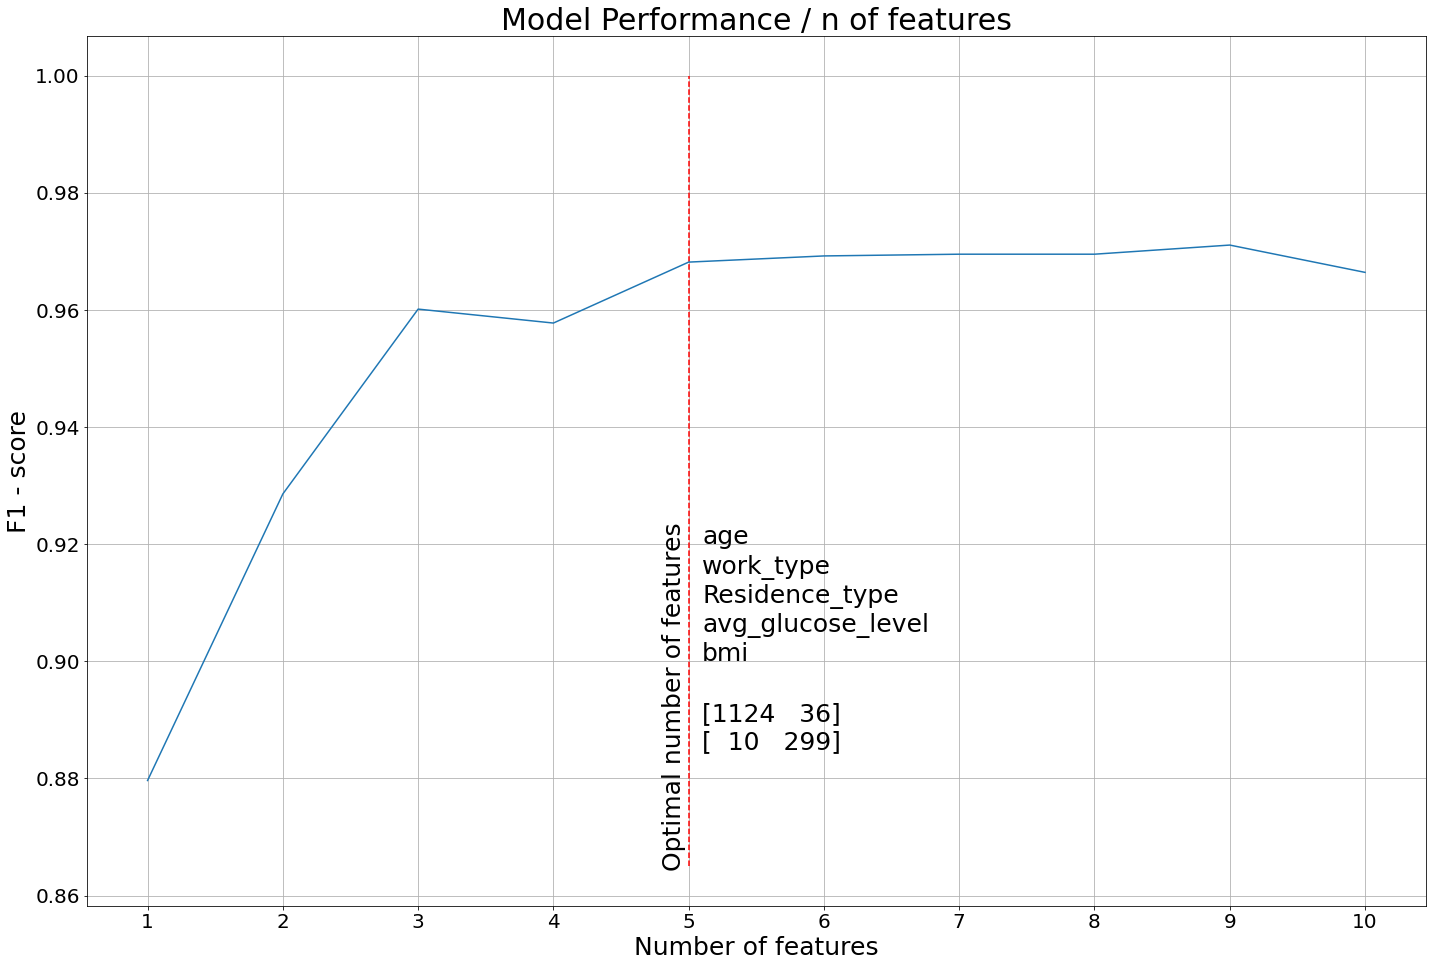

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

f1_scores = [test_scores[i][1]["F1"] for i in test_scores.keys()]
feats = [i for i in range(1,11)]

plt.figure(figsize=(24,16))
sns.lineplot(x = feats, y = f1_scores)

plt.annotate(text = "Optimal number of features\n",
             xy = (len(test_scores[5][0])-0.2,0.865),
             rotation = 90,
             size = 25)

plt.annotate(text = """[1124   36]
[  10   299]""",
                    xy = (5.1, 0.885),
                    size = 25)

yticker = 0.92
for i in test_scores[5][0]:
    plt.annotate(text = i, xy = (5.1, yticker), size = 25)
    yticker-=0.005
    
plt.vlines(x = 5, ymin = 0.865, ymax=1, colors="red", linestyles="dashed")

plt.title("Model Performance / n of features", size = 30)
plt.xlabel("Number of features", size=25)
plt.ylabel("F1 - score", size = 25)

plt.xticks(ticks = [i for i in range(1,11)], size = 20)
plt.yticks(size = 20)

plt.grid()
#plt.savefig('C:\\Users\\victo\\00_Nod_coding_bootcamp\\Week 9\\Project\\performancecurve_f1.png')
plt.show()

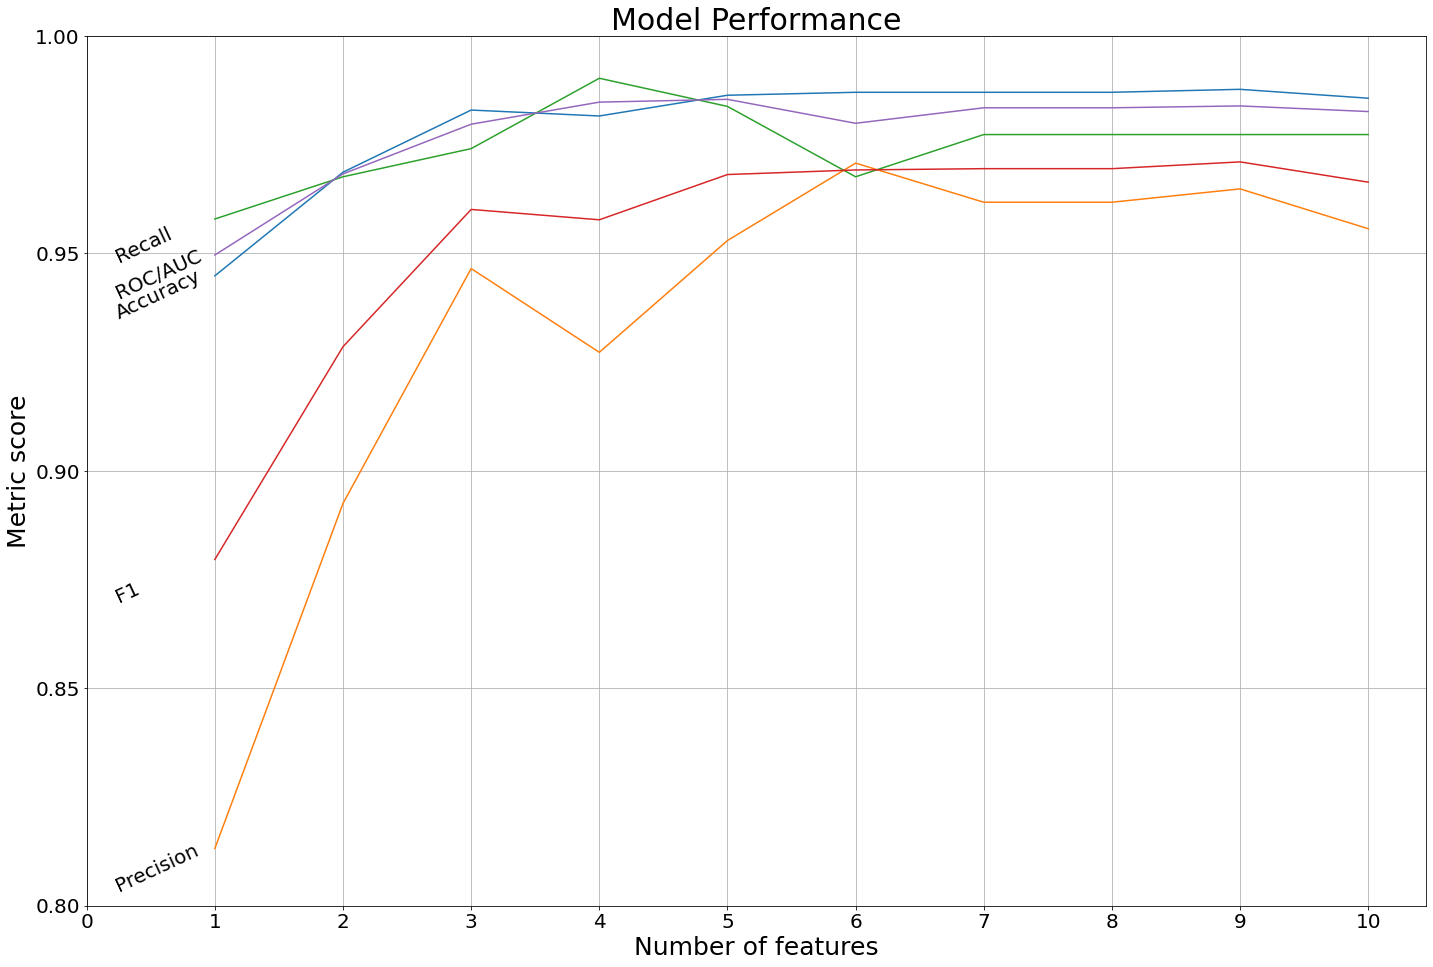

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

feats = [i for i in range(1,11)]
scores = [i for i in test_scores[1][1].keys()]

fig, ax = plt.subplots(1,1,figsize = (24,16))
y_tick = 0.905
for i in scores:
    y = []

    for k in test_scores.keys():
        y.append(test_scores[k][1][i])
    #plt.annotate(round(test_scores[k][1][i],4), xy=(6.05, y_tick), size = 15)
    #plt.annotate(f"Best {i}:", xy = (4.25, y_tick), size = 15)
    sns.lineplot(x = feats, y = y, ax = ax)
    plt.annotate(text = f"{i}", xy = (0.2, min(y)-0.01), rotation=25, size = 20)
    y_tick -= 0.015

plt.grid()
plt.title("Model Performance", size = 30)
plt.xlabel("Number of features", size=25)
plt.ylabel("Metric score", size = 25)
plt.xticks(ticks = [i for i in range(0,11)], size = 20)
plt.yticks(ticks = [0.80, 0.85, 0.90, 0.95, 1.0], size = 20)
#plt.savefig('C:\\Users\\victo\\00_Nod_coding_bootcamp\\Week 9\\Project\\performance_all_metrics.png')
plt.show()

# Perform hyperparameter optimization

### Random forest classifier

In [174]:
six_features = test_scores[6][0]

X_train_six = X_train[six_features]
y_train_six = y_train
X_test_six = X_test[six_features]
y_test_six = y_test

In [62]:
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)

n_estimators = [int(x) for x in np.linspace(start = 500, stop = 1500, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
                
random_grid = {'randomforestclassifier__n_estimators': n_estimators,
               'randomforestclassifier__max_features': max_features,
               'randomforestclassifier__max_depth': max_depth,
               'randomforestclassifier__min_samples_split': min_samples_split,
               'randomforestclassifier__min_samples_leaf': min_samples_leaf,
               'randomforestclassifier__bootstrap': bootstrap}

pipe = make_pipeline(preprocessing, RandomForestClassifier(random_state = 42))

search_rf = RandomizedSearchCV(estimator = pipe,
                            param_distributions = random_grid,
                            cv = cv,
                            scoring = "accuracy",
                            n_jobs = -1,
                            random_state = 42)